# Wikipedia Article Retrieval System

## Project Overview

This project focuses on developing a machine learning model capable of identifying the most appropriate Wikipedia article titles to answer specific user queries. The dataset for this task is sourced from the [Hugging Face Wikipedia dataset](https://huggingface.co/datasets/wikipedia/viewer/20220301.simple), specifically a subset of the Simple Wikipedia entries. The data set was provided by Ahrefs and includes a set of predefined questions along with their ideal Wikipedia article answers and associated point values.

The main objective is to construct a model that can accurately predict the Wikipedia article title that answers a given question, with the aim of maximizing the total points based on the dataset provided by Ahrefs.

## Authors

Tammie Koh and Alan Matthew

## Notebook Structure

The development process in this notebook is organized into three primary sections:

1. **Data Exploration and Preprocessing:** This section involves examining the dataset for quality and preparing it for modeling through various preprocessing techniques.
2. **Model Experimentations:** Here, various machine learning models and hyperparameters are tested to determine the most effective approach for predicting the correct Wikipedia article titles.
3. **Model Evaluation:** The final section assesses the performance of different models to identify the most accurate one for this task. A summary of the results and key findings will be provided, outlining the effectiveness of the chosen approach.

The project's deliverables will include a comprehensive Python notebook detailing the methodology, model experimentation, and evaluation results, showcasing both the technical and analytical aspects of applying machine learning to solve real-world information retrieval challenges.

Let us first install and import the necessary libraries for this project.

In [56]:
import warnings
warnings.filterwarnings('ignore')

# data loading and transformation
from datasets import load_dataset
import pandas as pd
import numpy as np
from collections import Counter

# data cleaning
import re
from textstat import flesch_reading_ease

# NLP text manipulation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess

# NLP text analysis
import spacy
!python -m spacy download en_core_web_md

# data visualisation
import matplotlib.pyplot as plt

import psutil

[nltk_data] Downloading package punkt to /Users/tammiekoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tammiekoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tammiekoh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## Section 1: Data Exploration and Preprocessing

In this initial section, we will evaluate the quality of the data and prepare it for modeling. We start by loading and examining the Wikipedia dataset.

This dataset, which we refer to as `articles`, comes from the [Hugging Face Simple Wikipedia dataset](https://huggingface.co/datasets/wikipedia/viewer/20220301.simple) and includes the first 10,000 articles, providing the context for the questions in our task. The dataset provided by Ahrefs, referred to as `qns_answers`, consists of questions paired with the corresponding Wikipedia article titles that serve as answers, limited to the first 10k articles from the `articles` dataset.

Let's begin by loading the dataset and inspecting a few entries to understand its structure and contents.

In [57]:
# Load the Simple Wikipedia dataset, specifying only the first 10k entries
dataset = load_dataset('wikipedia', '20220301.simple', split='train[:10000]', trust_remote_code=True)

print(dataset)

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 10000
})


In [58]:
articles = dataset.to_pandas()
print(f"We have {articles.shape[0]} articles in the dataset and {articles.shape[1]} columns.")
articles.head()

We have 10000 articles in the dataset and 4 columns.


,id,url,title,text
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...


In [59]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   url     10000 non-null  object
 2   title   10000 non-null  object
 3   text    10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [60]:
summary = pd.DataFrame({
  'NA Count': articles.isna().sum(),
  'Unique Count': articles.nunique(),
  'Duplicate Count': articles.duplicated().sum(),
})
summary

,NA Count,Unique Count,Duplicate Count
id,0,10000,0
url,0,10000,0
title,0,10000,0
text,0,10000,0


The wikipedia data set contains four columns, namely, `id`, `url`, `title`, and `text`. The `id` column is a unique identifier for each row, the `url` column contains the url of the wikipedia article, the `title` column contains the title of the wikipedia article, and the `text` column contains the text of the wikipedia article. Moreover, there are 205,327 rows in the data set. There are no missing values in the data set and there are no duplicate rows.

With this evaluation, we can proceed with loading the training set, which contains the model answers to possible questions from Ahrefs's take home assessment, which is generated from their own in-house LLM model LongCaml.

For reference, the data can be found in the `data` folder.

In [61]:
qns_answers = pd.read_json('./data/wiki_qns_articles.jsonl', lines=True)
print(f"We have {qns_answers.shape[0]} questions in the dataset and {qns_answers.shape[1]} columns.")
qns_answers.head()

We have 21761 questions in the dataset and 3 columns.


,question,points,article
0,how do living organisms in a natural environme...,57,Environment
1,what is the name of the poem written by juan r...,72,Marcha Real
2,what body parts can mri scans study?,45,Magnetic resonance imaging
3,what are the names of the 12 boroughs in berli...,46,Boroughs of Berlin
4,what was the cause of charles dickens' death?,87,Heinrich Rudolf Hertz


In [62]:
qns_answers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21761 entries, 0 to 21760
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  21761 non-null  object
 1   points    21761 non-null  int64 
 2   article   21761 non-null  object
dtypes: int64(1), object(2)
memory usage: 680.0+ KB


In [63]:
summary = pd.DataFrame({
  'NA Count': qns_answers.isna().sum(),
  'Unique Count': qns_answers.nunique(),
  'Duplicate Count': qns_answers.duplicated().sum(),
})
print(summary)

          NA Count  Unique Count  Duplicate Count
question         0         21325               31
points           0            80               31
article          0          9649               31


The data contains three columns, namely, `question`, `points` and `article`. The `question` column contains the question, the `points` column contains the points assigned to the question, and the `article` column contains the wikipedia article title. There are 21,761 rows in the training set. There are no missing values in the training set but we do have duplicate questions.

Let us further explore the duplicates in the training set. We will group the data by the `question` column and count the number of rows in each group. We will then filter the data to show only the rows where the count is greater than 1. 

In [64]:
repeating_questions = qns_answers[qns_answers.duplicated(subset='question', keep=False)]
repeating_questions_counts = repeating_questions.groupby('question').size().reset_index(name='count')
pd.set_option('display.max_colwidth', None) # to show full text

print(repeating_questions_counts)

                                                                                           question  \
0                                                                                                     
1    can a man with oligospermia or azoospermia still make a woman pregnant by having sex with her?   
2                                                 what are some common diseases caused by bacteria?   
3                                what are some of the most common crops grown in the united states?   
4                            what are some of the most influential english rock bands of the 1960s?   
..                                                                                              ...   
249                           who was the prime minister of the united kingdom during world war ii?   
250                                                        who was the roman god of the underworld?   
251                                                         who was willi

For these questions, let us see if they map to the same wikipedia article. 

In [65]:
# Merging this information back to get the articles for each repeating question
repeating_questions_with_articles = pd.merge(repeating_questions, repeating_questions_counts, on='question')

# Group by question and aggregate both articles and points into lists
questions_articles_points_mapping = repeating_questions_with_articles.groupby('question').agg({
    'article': lambda x: list(x),
    'points': lambda x: list(x)
}).reset_index()

print(questions_articles_points_mapping)

                                                                                           question  \
0                                                                                                     
1    can a man with oligospermia or azoospermia still make a woman pregnant by having sex with her?   
2                                                 what are some common diseases caused by bacteria?   
3                                what are some of the most common crops grown in the united states?   
4                            what are some of the most influential english rock bands of the 1960s?   
..                                                                                              ...   
249                           who was the prime minister of the united kingdom during world war ii?   
250                                                        who was the roman god of the underworld?   
251                                                         who was willi

Just from a superficial scan, most of the articles are from a similar topic. However, let us see if any of these repeating questions map to the same wikipedia article.

In [66]:
# Filter to find entries with only one article in the 'articles' list
questions_articles_mapping = repeating_questions_with_articles.groupby('question')['article'].apply(list).reset_index(name='articles')
questions_articles_mapping[questions_articles_mapping['articles'].apply(len) == 1]

,question,articles


It appears that there are no repeating questions that map to the same article. Let us remove the duplicates in the training set and keep the row with the highest points to ensure that we have the best answer for each question.

In [67]:
# Step 1: Sort by 'question' and 'points' in descending order to ensure the highest points are first
qns_answers_sorted = qns_answers.sort_values(by=['question', 'points'], ascending=[True, False])

# Step 2: Drop duplicates based on 'question', keeping the first one (highest points now)
qns_answers_deduped = qns_answers_sorted.drop_duplicates(subset='question', keep='first')

# Reset index if needed
qns_answers_deduped.reset_index(drop=True, inplace=True)

qns_answers = qns_answers_deduped

# Check for duplicates
summary = pd.DataFrame({
  'NA Count': qns_answers.isna().sum(),
  'Unique Count': qns_answers.nunique(),
  'Duplicate Count': qns_answers.duplicated().sum(),
})
print(summary)
print(qns_answers)

          NA Count  Unique Count  Duplicate Count
question         0         21325                0
points           0            80                0
article          0          9607                0
                                                                                                                                                     question  \
0                                                                                                                                                               
1                                                               did the people of gibraltar vote to remain part of the united kingdom in the 2002 referendum?   
2                                                                                                      which country uses the franc as its official currency?   
3                                                                                                which of these old communist parties no longer exists today

Moreover, analysis of the `repeating_questions_counts` reveals some structural issues in the dataset. To improve data quality, we will clean up entries that fall into any of the following categories:
1. Questions that are empty strings.
2. Questions containing an unpaired opening bracket `{`, indicating a formatting error.
3. Questions lacking a question mark, which may signify incomplete or incorrectly formatted entries.

In [68]:
# finding the empty questions
empty_questions = qns_answers[qns_answers['question'] == ""]
empty_questions

,question,points,article
0,,119,Hormone


Let's remove the empty questions as the logic for their emptiness is arbitrary.

In [69]:
qns_answers = qns_answers[qns_answers['question'] != ""]

Let us now find the questions with hanging brackets and remove them.

In [70]:
questions_with_brackets = qns_answers[qns_answers['question'].str.contains('\{|\}')]
print(questions_with_brackets)

                                                                                                                     question  \
360                                                                                           how did kerouac feel about his}   
576                                                                      how many cars did ford motor company produce in 190}   
584                                                                                                    how many counties did}   
1654                              what are some of the unique cultural traditions and practices of the roman catholic church}   
2986                                                    what are the reasons for space exploration according to the article?}   
3014                                                                    what are the seraphim known for singing and praising}   
3227                                                       what are the three main types of lymph

Finally, let us find the questions without question marks and add a question mark to the end of the question.

In [71]:
questions_without_question_mark = qns_answers[~qns_answers['question'].str.contains('\?')]
questions_without_question_mark

,question,points,article
8,aquamarine,93,May 28
360,how did kerouac feel about his},62,Jack Kerouac
469,how does adam smith's concept of the,59,Adam Smith
576,how many cars did ford motor company produce in 190},52,Ford Motor Company
584,how many counties did},98,Kenya
...,...,...,...
19549,who played the role of jill masterson in the james bond film 'goldfinger,46,Goldfinger (movie)
19560,who played the role of sam malone in the tv show 'cheers,61,Ted Danson
20734,who was the main political party of},90,October 13
21226,who},105,Poland


In [72]:
# Remove the brackets from the questions
qns_answers['question'] = qns_answers['question'].str.replace('[{}]', '', regex=True)

# Adding a question mark to the end of these questions
qns_answers.loc[~qns_answers['question'].str.contains('\?'), 'question'] = qns_answers['question'] + '?'

The dataset includes grammatically incorrect or incomplete questions, such as "how many counties did." To address these issues, we will employ Named Entity Recognition (NER) to identify sentences with contextually incomplete named entities. Additionally, we will use dependency parsing to detect sentences that exhibit irregular or grammatically incorrect structures. This methodical approach will help us systematically identify and rectify questions that require cleaning.

In [73]:
nlp = spacy.load('en_core_web_md')  

def sentence_structures(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents] # NER
    token_dependencies = [(token.text, token.dep_, token.head.text) for token in doc] # dependency parsing
    return entities, token_dependencies

qns_answers['nlp_analysis'] = qns_answers['question'].apply(sentence_structures)


In [74]:
qns_answers.head()

,question,points,article,nlp_analysis
1,did the people of gibraltar vote to remain part of the united kingdom in the 2002 referendum?,58,Gibraltar,"([(the united kingdom, GPE), (2002, DATE)], [( , dep, did), (did, aux, remain), (the, det, people), (people, nsubj, remain), (of, prep, people), (gibraltar, compound, vote), (vote, pobj, of), (to, aux, remain), (remain, ROOT, remain), (part, attr, remain), (of, prep, part), (the, det, kingdom), (united, compound, kingdom), (kingdom, pobj, of), (in, prep, remain), (the, det, referendum), (2002, nummod, referendum), (referendum, pobj, in), (?, punct, remain)])"
2,which country uses the franc as its official currency?,55,Currency,"([], [( , dep, which), (which, det, country), (country, nsubj, uses), (uses, ROOT, uses), (the, det, franc), (franc, dobj, uses), (as, prep, uses), (its, poss, currency), (official, amod, currency), (currency, pobj, as), (?, punct, uses)])"
3,which of these old communist parties no longer exists today?,52,List of communist parties,"([(communist, NORP), (today, DATE)], [( , dep, which), (which, nsubj, exists), (of, prep, which), (these, det, parties), (old, amod, parties), (communist, amod, parties), (parties, pobj, of), (no, neg, longer), (longer, advmod, exists), (exists, ROOT, exists), (today, npadvmod, exists), (?, punct, exists)])"
4,"a patient has a terminal illness and wants to end their life, but their family members are opposed to it. how should the doctor handle this situation?",65,Medical ethics,"([], [(a, det, patient), (patient, nsubj, has), (has, ROOT, has), (a, det, illness), (terminal, amod, illness), (illness, dobj, has), (and, cc, has), (wants, conj, has), (to, aux, end), (end, xcomp, wants), (their, poss, life), (life, dobj, end), (,, punct, has), (but, cc, has), (their, poss, members), (family, compound, members), (members, nsubj, are), (are, conj, has), (opposed, acomp, are), (to, prep, opposed), (it, pobj, to), (., punct, are), (how, advmod, handle), (should, aux, handle), (the, det, doctor), (doctor, nsubj, handle), (handle, ROOT, handle), (this, det, situation), (situation, dobj, handle), (?, punct, handle)])"
5,"according to plato, what are the three types of people that society should be made up of?",55,The Republic,"([(three, CARDINAL)], [(according, prep, are), (to, prep, according), (plato, pobj, to), (,, punct, are), (what, attr, are), (are, ROOT, are), (the, det, types), (three, nummod, types), (types, nsubj, are), (of, prep, types), (people, pobj, of), (that, mark, made), (society, nsubjpass, made), (should, aux, made), (be, auxpass, made), (made, relcl, types), (up, prt, made), (of, prep, up), (?, punct, are)])"


We can see that the questions are now categorized based on their syntactic structures and named entities have been identified via Named Entity Recognition (NER) and dependency parsing. Each entry combines named entities, highlighting specific people, places, dates, or other relevant information, with the grammatical relationships between words to show the sentence structure of each question.

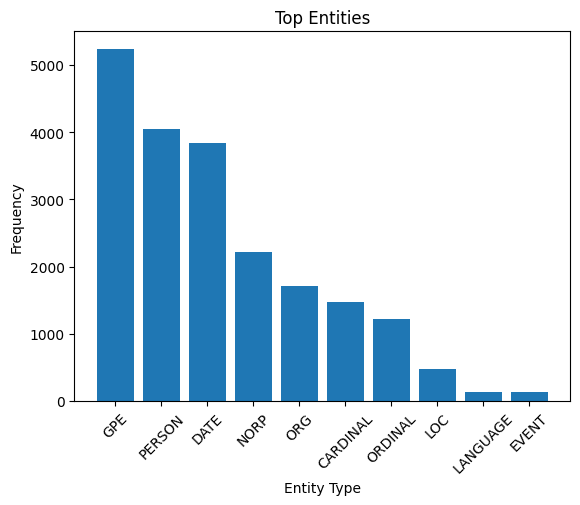

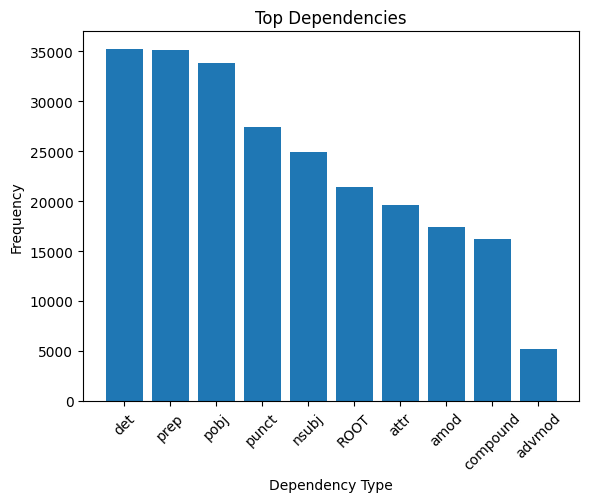

In [75]:
entity_counter = Counter()
dependency_counter = Counter()

for _, row in qns_answers.iterrows():
    entities, dependencies = row['nlp_analysis']
    entity_counter.update([ent[1] for ent in entities])  # count entity types
    dependency_counter.update([dep[1] for dep in dependencies])  # count dependency types

top_entities = entity_counter.most_common(10)
top_dependencies = dependency_counter.most_common(10)

def plot_data(data, title, xlabel, ylabel):
    labels, values = zip(*data)
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

plot_data(top_entities, 'Top Entities', 'Entity Type', 'Frequency')
plot_data(top_dependencies, 'Top Dependencies', 'Dependency Type', 'Frequency')

From the breakdown, we can see that for the entities chart Geopolitical Entities (GPE) are the most common entities. This suggests that locations, like countries, cities, states, etc., are the most frequently mentioned in the dataset. This might indicate a focus on geographical information or questions related to places. Followed by persons and dates, which implies that questions likely pertain to historical figures, celebrities, or events tied to specific dates. There are also CARDINAL (basic numbers) and ORDINAL (e.g. "first") entities which suggest that questions often involve counting or ordering e.g. rankings/ quantities. The rest of the entities: ORG (organizations), LOC (locations), LANGUAGE, and EVENT indicate a wide range of topics covered in the questions.

For the dependencies chart, the most frequent dependency types are det (determiners), prep (prepositions), pobj (objects of prepositions), and punct (punctuation), which are foundational to sentence structure, indicating that many sentences are likely grammatically well-formed. For example, in "What is the name of the river?", "the" serves as a determiner (det) indicating specificity, "of" is a preposition (prep) establishing a relationship, and "river" acts as the object of the preposition (pobj), all rounded off with a question mark as punctuation (punct). Additionally, the frequent occurrence of ROOT dependencies, which spotlight the main verb or action, like "is" in the aforementioned question, aligns with the expectation for well-structured queries centered around a verb.

Conversely, the presence of adverbial modifiers (advmod), which are words that modify or change the meaning of a verb, an adjective, or another adverb, often by providing more detail about the manner, place, time, frequency, degree, or cause of the action or characteristic described is rarer. This suggests that questions tend towards being more direct and less embellished, a typical characteristic of question-answer datasets.

Despite the generally correct grammar, we will further investigate and address any grammatically incorrect questions to ensure the data is optimal for model training.

In [76]:
# Check if there are any questions a root
def has_root(dependencies):
    flag = any(dep[1] == 'ROOT' for dep in dependencies)
    return flag

# Filter to find questions without a root
subset_no_root = qns_answers[
    ~qns_answers['nlp_analysis'].apply(lambda x: has_root(x[1]))
]

subset_no_root

,question,points,article,nlp_analysis


There are no questions missing the ROOT dependency.

In [77]:
# Check if there are any questions with a subject
def has_subject(dependencies):
    flag = any(dep[1] == 'nsubj' for dep in dependencies)
    return flag

# Filter to find questions without a subject
subset_no_subject = qns_answers[
    ~qns_answers['nlp_analysis'].apply(lambda x: has_subject(x[1]))
]

subset_no_subject

,question,points,article,nlp_analysis
8,aquamarine?,93,May 28,"([], [(aquamarine, ROOT, aquamarine), (?, punct, aquamarine)])"
9,are a and b the same number?,78,Axiom,"([], [(are, ROOT, are), (a, attr, are), (and, cc, a), (b, conj, a), (the, det, number), (same, amod, number), (number, attr, are), (?, punct, are)])"
10,are addition and multiplication dyadic functions?,48,Dyadic,"([], [(are, ROOT, are), (addition, nmod, functions), (and, cc, addition), (multiplication, conj, addition), (dyadic, amod, functions), (functions, attr, are), (?, punct, are)])"
11,are albinic animals more likely to be attacked by predators than non-albino animals in the wild?,57,Albinism,"([(albinic, NORP)], [(are, ROOT, are), (albinic, amod, animals), (animals, attr, are), (more, advmod, likely), (likely, amod, animals), (to, aux, attacked), (be, auxpass, attacked), (attacked, xcomp, likely), (by, agent, attacked), (predators, pobj, by), (than, prep, predators), (non, amod, animals), (-, amod, animals), (albino, amod, animals), (animals, pobj, than), (in, prep, attacked), (the, det, wild), (wild, pobj, in), (?, punct, are)])"
12,are animal by-products used in the production of non-human foods?,48,By-product,"([], [(are, ROOT, are), (animal, acomp, are), (by, prep, animal), (-, punct, products), (products, pobj, by), (used, acl, products), (in, prep, used), (the, det, production), (production, pobj, in), (of, prep, production), (non, amod, foods), (-, amod, foods), (human, amod, foods), (foods, pobj, of), (?, punct, are)])"
...,...,...,...,...
21303,why is glass used for laboratory rods?,44,Glass rod,"([], [(why, advmod, used), (is, auxpass, used), (glass, nsubjpass, used), (used, ROOT, used), (for, prep, used), (laboratory, compound, rods), (rods, pobj, for), (?, punct, used)])"
21305,why is inbreeding likely to result in a loss of viability in a population?,47,Inbreeding,"([], [(why, advmod, inbreeding), (is, aux, inbreeding), (inbreeding, ROOT, inbreeding), (likely, advmod, inbreeding), (to, aux, result), (result, xcomp, likely), (in, prep, result), (a, det, loss), (loss, pobj, in), (of, prep, loss), (viability, pobj, of), (in, prep, loss), (a, det, population), (population, pobj, in), (?, punct, inbreeding)])"
21311,why might something be kept secret forever?,55,Secrecy,"([], [(why, advmod, kept), (might, aux, kept), (something, nsubjpass, kept), (be, auxpass, kept), (kept, ROOT, kept), (secret, oprd, kept), (forever, advmod, kept), (?, punct, kept)])"
21321,will rabat be selected to host the 2020 summer olympics?,72,Rabat,"([(2020 summer, DATE)], [(will, aux, rabat), (rabat, nsubjpass, selected), (be, auxpass, selected), (selected, ROOT, selected), (to, aux, host), (host, xcomp, selected), (the, det, olympics), (2020, nummod, olympics), (summer, compound, olympics), (olympics, dobj, host), (?, punct, selected)])"


The presence of a 'nsubj' (nominal subject) in the dependency parse is typically a good indicator of a well-formed question, but it's not infallible. Some types of questions, particularly those starting with "what" or "which" used as interrogatives, may not explicitly require a nominal subject in the same way declarative sentences do. Additionally, imperative sentences and some types of passive constructions might not show a 'nsubj' as well.

Moving forward, we can check for auxillary verbs instead. In many questions, especially those that do not start with "who" or "what" as the subject, an auxiliary verb is present. We can also ensure that questions start with an interrogative word (who, what, where, when, why, or how), which might be labeled with dependencies such as 'advmod' for adverbial modifiers or 'dobj' for direct objects in the case of "what" or "which" used as direct objects.

In [78]:
# Check if there are any questions with an auxiliary or interrogative
def has_auxiliary_or_interrogative(dependencies):
    has_aux = any(dep[1] in ('aux', 'auxpass') for dep in dependencies)
    interrogative_words = ['who', 'what', 'where', 'when', 'why', 'how']
    has_interrogative = any(dep[0].lower() in interrogative_words for dep in dependencies)
    return has_aux or has_interrogative

# Filter to find questions without an auxiliary or interrogative
subset_issues = qns_answers[
    ~qns_answers['nlp_analysis'].apply(lambda x: has_auxiliary_or_interrogative(x[1]))
]

subset_issues

,question,points,article,nlp_analysis
2,which country uses the franc as its official currency?,55,Currency,"([], [( , dep, which), (which, det, country), (country, nsubj, uses), (uses, ROOT, uses), (the, det, franc), (franc, dobj, uses), (as, prep, uses), (its, poss, currency), (official, amod, currency), (currency, pobj, as), (?, punct, uses)])"
3,which of these old communist parties no longer exists today?,52,List of communist parties,"([(communist, NORP), (today, DATE)], [( , dep, which), (which, nsubj, exists), (of, prep, which), (these, det, parties), (old, amod, parties), (communist, amod, parties), (parties, pobj, of), (no, neg, longer), (longer, advmod, exists), (exists, ROOT, exists), (today, npadvmod, exists), (?, punct, exists)])"
8,aquamarine?,93,May 28,"([], [(aquamarine, ROOT, aquamarine), (?, punct, aquamarine)])"
9,are a and b the same number?,78,Axiom,"([], [(are, ROOT, are), (a, attr, are), (and, cc, a), (b, conj, a), (the, det, number), (same, amod, number), (number, attr, are), (?, punct, are)])"
10,are addition and multiplication dyadic functions?,48,Dyadic,"([], [(are, ROOT, are), (addition, nmod, functions), (and, cc, addition), (multiplication, conj, addition), (dyadic, amod, functions), (functions, attr, are), (?, punct, are)])"
...,...,...,...,...
18669,"which whig party politician served as prime minister of great britain twice, first from 1765 to 1768 and then again from 1782 to 1783?",60,Robert Walpole,"([(britain, GPE), (first, ORDINAL), (1765 to 1768, DATE), (1782 to, DATE), (1783, DATE)], [(which, det, politician), (whig, compound, party), (party, compound, politician), (politician, nsubj, served), (served, ROOT, served), (as, prep, served), (prime, amod, minister), (minister, pobj, as), (of, prep, minister), (great, amod, britain), (britain, pobj, of), (twice, advmod, served), (,, punct, served), (first, advmod, served), (from, prep, first), (1765, pobj, from), (to, prep, from), (1768, pobj, to), (and, cc, first), (then, advmod, again), (again, conj, first), (from, prep, again), (1782, pobj, from), (to, prep, from), (1783, pobj, to), (?, punct, served)])"
18676,which year was emmanuel iii delly born?,86,October 6,"([(which year, DATE), (emmanuel iii delly, PERSON)], [(which, det, year), (year, nsubj, was), (was, ROOT, was), (emmanuel, compound, iii), (iii, attr, was), (delly, advmod, born), (born, acl, iii), (?, punct, was)])"
18677,which year was ragnar granit born?,91,October 30,"([(ragnar granit, PERSON)], [(which, det, year), (year, nsubj, was), (was, ROOT, was), (ragnar, attr, was), (granit, nsubj, born), (born, relcl, ragnar), (?, punct, was)])"
18678,which yoshi character has a green game card in super mario 64 ds's vs mode multiplayer?,49,Yoshi,"([(yoshi, PERSON), (mario 64 ds's, FAC)], [(which, det, character), (yoshi, compound, character), (character, nsubj, has), (has, ROOT, has), (a, det, card), (green, amod, card), (game, compound, card), (card, dobj, has), (in, prep, card), (super, amod, mario), (mario, pobj, in), (64, nummod, ds), (ds, appos, mario), ('s, case, ds), (vs, prep, ds), (mode, compound, multiplayer), (multiplayer, pobj, vs), (?, punct, has)])"


However, the dependency parsing is still not comprehensive enough. This includes some manual adjustments to the filter (i.e. including 'which' and sentences with no nominal subject (`nsubj` and `nsubjpass`)).

In [79]:
def has_auxiliary_or_interrogative(dependencies):
    has_aux = any(dep[1] in ('aux', 'auxpass') for dep in dependencies)
    interrogative_words = ['who', 'what', 'where', 'when', 'why', 'how', 'which']
    has_interrogative = any(dep[0].lower() in interrogative_words for dep in dependencies)
    return has_aux or has_interrogative

subset_issues = qns_answers[
    ~qns_answers['nlp_analysis'].apply(lambda x: has_auxiliary_or_interrogative(x[1]))
]

subset_issues = subset_issues[
    ~subset_issues['nlp_analysis'].apply(lambda x: has_subject(x[1]))
]

subset_issues

,question,points,article,nlp_analysis
8,aquamarine?,93,May 28,"([], [(aquamarine, ROOT, aquamarine), (?, punct, aquamarine)])"
9,are a and b the same number?,78,Axiom,"([], [(are, ROOT, are), (a, attr, are), (and, cc, a), (b, conj, a), (the, det, number), (same, amod, number), (number, attr, are), (?, punct, are)])"
10,are addition and multiplication dyadic functions?,48,Dyadic,"([], [(are, ROOT, are), (addition, nmod, functions), (and, cc, addition), (multiplication, conj, addition), (dyadic, amod, functions), (functions, attr, are), (?, punct, are)])"
12,are animal by-products used in the production of non-human foods?,48,By-product,"([], [(are, ROOT, are), (animal, acomp, are), (by, prep, animal), (-, punct, products), (products, pobj, by), (used, acl, products), (in, prep, used), (the, det, production), (production, pobj, in), (of, prep, production), (non, amod, foods), (-, amod, foods), (human, amod, foods), (foods, pobj, of), (?, punct, are)])"
14,are avocados considered a fruit or a vegetable in everyday speech?,56,List of fruits,"([], [(are, ROOT, are), (avocados, attr, are), (considered, acl, avocados), (a, det, fruit), (fruit, oprd, considered), (or, cc, fruit), (a, det, vegetable), (vegetable, conj, fruit), (in, prep, considered), (everyday, amod, speech), (speech, pobj, in), (?, punct, are)])"
...,...,...,...,...
961,was the parkes observatory the primary site used by nasa for the reception of the apollo 11 moon landings?,65,Radio telescope,"([(parkes, GPE), (nasa, ORG)], [(was, ROOT, was), (the, det, observatory), (parkes, compound, observatory), (observatory, attr, was), (the, det, site), (primary, amod, site), (site, attr, was), (used, acl, site), (by, agent, used), (nasa, pobj, by), (for, prep, used), (the, det, reception), (reception, pobj, for), (of, prep, reception), (the, det, landings), (apollo, nmod, landings), (11, nummod, apollo), (moon, compound, landings), (landings, pobj, of), (?, punct, was)])"
963,was there any confirmed instance of axis-instigated sabotage on the manhattan project?,55,Manhattan Project,"([(manhattan, GPE)], [(was, ROOT, was), (there, expl, was), (any, det, instance), (confirmed, amod, instance), (instance, attr, was), (of, prep, instance), (axis, npadvmod, instigated), (-, punct, instigated), (instigated, amod, sabotage), (sabotage, pobj, of), (on, prep, sabotage), (the, det, project), (manhattan, compound, project), (project, pobj, on), (?, punct, was)])"
964,was viktor yanukovych ever imprisoned for violent crimes?,52,Viktor Yanukovych,"([(viktor yanukovych, PERSON)], [(was, ROOT, was), (viktor, compound, yanukovych), (yanukovych, attr, was), (ever, advmod, imprisoned), (imprisoned, acl, yanukovych), (for, prep, imprisoned), (violent, amod, crimes), (crimes, pobj, for), (?, punct, was)])"
971,were there any recorded instances of cannibalism in modern societies?,47,Cannibalism,"([], [(were, ROOT, were), (there, expl, were), (any, det, instances), (recorded, amod, instances), (instances, attr, were), (of, prep, instances), (cannibalism, pobj, of), (in, prep, instances), (modern, amod, societies), (societies, pobj, in), (?, punct, were)])"


We still need to remove questions with the pattern 'is' and 'are' at the start of the question (i.e. existential questions), where 'is' and 'are' are identified as roots.

In [80]:
# Check if there are any questions with an existential question structure
def has_existential(dependencies):
    flag = any((dep[0].lower() == 'is' or dep[0].lower() == 'are' or dep[0].lower() == 'was' or dep[0].lower() == 'were') and dep[1] == 'ROOT' for dep in dependencies)
    return flag


# Filter to find questions without an existential question structure
subset_issues = subset_issues[
    ~subset_issues['nlp_analysis'].apply(lambda x: has_existential(x[1]))
]

subset_issues

,question,points,article,nlp_analysis
8,aquamarine?,93,May 28,"([], [(aquamarine, ROOT, aquamarine), (?, punct, aquamarine)])"
942,ma? 你知道四月的生日stone吗？,91,Tone language,"([(ma, ORG), (你知道四月的生日stone吗？, PERSON)], [(ma, ROOT, ma), (?, punct, ma), (你知道四月的生日stone吗, ROOT, 你知道四月的生日stone吗), (？, punct, 你知道四月的生日stone吗)])"
21323,?,105,Eel,"([], [(?, ROOT, ?)])"


From this output, we can remove these questions as their logic seems to be arbitrary (i.e. there is no logical reasoning for mapping the question to the articles). 

In [81]:
indices_to_drop = [8, 942, 21323]

qns_answers = qns_answers.drop(indices_to_drop).reset_index(drop=True)

Moreover, the analysis was quite restrictive. Another way we can find questions with issues is by checking for questions with very few dependencies.

In [82]:
entries_with_few_dependencies = qns_answers[
    qns_answers['nlp_analysis'].apply(lambda x: len(x[1]) < 5)
]

entries_with_few_dependencies

,question,points,article,nlp_analysis
760,is austria landlocked?,54,Landlocked country,"([(austria, GPE)], [(is, ROOT, is), (austria, nsubj, landlocked), (landlocked, acomp, is), (?, punct, is)])"
3541,what causes earthquakes?,51,Earthquake,"([], [(what, nsubj, causes), (causes, ROOT, causes), (earthquakes, dobj, causes), (?, punct, causes)])"
14360,what is the?,109,19th century,"([], [(what, attr, is), (is, ROOT, is), (the, nsubj, is), (?, punct, is)])"
17104,what?,115,March,"([], [(what, ROOT, what), (?, punct, what)])"
18765,who invented lithography?,100,1798,"([], [(who, nsubj, invented), (invented, ROOT, invented), (lithography, dobj, invented), (?, punct, invented)])"
18847,who is kabir?,88,Hindi,"([], [(who, nsubj, is), (is, ROOT, is), (kabir, acomp, is), (?, punct, is)])"
18873,who is saladin?,78,1187,"([], [(who, nsubj, saladin), (is, aux, saladin), (saladin, ROOT, saladin), (?, punct, saladin)])"
19812,who was massasoit?,76,1621,"([], [(who, nsubj, was), (was, ROOT, was), (massasoit, acomp, was), (?, punct, was)])"
21223,who?,105,Poland,"([], [(who, ROOT, who), (?, punct, who)])"


From here, we have identified a few more incomplete questions and we can remove them

In [83]:
# Rows with few dependencies that are grammatically incorrect
indices_to_drop = [14360, 17104, 21223]

# Drop these rows
qns_answers = qns_answers.drop(indices_to_drop).reset_index(drop=True)

## Section 2: Visualizing the Distribution of Points

In this section, we will explore the distribution of points in the training set by plotting a histogram. This visual representation will help us understand how the points are distributed across different questions, providing insights into the weighting of each query in the dataset.

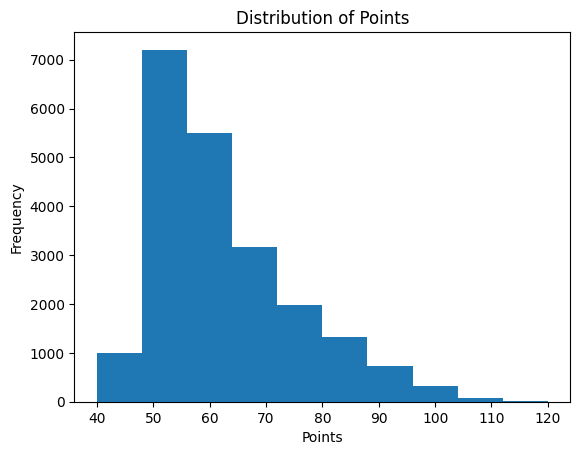

In [84]:
plt.hist(qns_answers['points'], bins=10)
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Distribution of Points')
plt.show()

In [85]:
questions_40_60 = qns_answers[(qns_answers['points'] >= 40) & (qns_answers['points'] <= 60)]
questions_40_60

,question,points,article,nlp_analysis
0,did the people of gibraltar vote to remain part of the united kingdom in the 2002 referendum?,58,Gibraltar,"([(the united kingdom, GPE), (2002, DATE)], [( , dep, did), (did, aux, remain), (the, det, people), (people, nsubj, remain), (of, prep, people), (gibraltar, compound, vote), (vote, pobj, of), (to, aux, remain), (remain, ROOT, remain), (part, attr, remain), (of, prep, part), (the, det, kingdom), (united, compound, kingdom), (kingdom, pobj, of), (in, prep, remain), (the, det, referendum), (2002, nummod, referendum), (referendum, pobj, in), (?, punct, remain)])"
1,which country uses the franc as its official currency?,55,Currency,"([], [( , dep, which), (which, det, country), (country, nsubj, uses), (uses, ROOT, uses), (the, det, franc), (franc, dobj, uses), (as, prep, uses), (its, poss, currency), (official, amod, currency), (currency, pobj, as), (?, punct, uses)])"
2,which of these old communist parties no longer exists today?,52,List of communist parties,"([(communist, NORP), (today, DATE)], [( , dep, which), (which, nsubj, exists), (of, prep, which), (these, det, parties), (old, amod, parties), (communist, amod, parties), (parties, pobj, of), (no, neg, longer), (longer, advmod, exists), (exists, ROOT, exists), (today, npadvmod, exists), (?, punct, exists)])"
4,"according to plato, what are the three types of people that society should be made up of?",55,The Republic,"([(three, CARDINAL)], [(according, prep, are), (to, prep, according), (plato, pobj, to), (,, punct, are), (what, attr, are), (are, ROOT, are), (the, det, types), (three, nummod, types), (types, nsubj, are), (of, prep, types), (people, pobj, of), (that, mark, made), (society, nsubjpass, made), (should, aux, made), (be, auxpass, made), (made, relcl, types), (up, prt, made), (of, prep, up), (?, punct, are)])"
5,"after ten half-lives, what percentage of the original atoms remain?",56,Half-life (element),"([(ten half, CARDINAL)], [(after, prep, remain), (ten, nummod, lives), (half, amod, lives), (-, punct, lives), (lives, pobj, after), (,, punct, remain), (what, det, percentage), (percentage, nsubj, remain), (of, prep, percentage), (the, det, atoms), (original, amod, atoms), (atoms, pobj, of), (remain, ROOT, remain), (?, punct, remain)])"
...,...,...,...,...
21309,why was night of the living dead initially criticized for its explicit content?,60,Night of the Living Dead,"([], [(why, advmod, was), (was, auxpass, criticized), (night, nsubj, was), (of, prep, night), (the, det, living), (living, pobj, of), (dead, nummod, night), (initially, advmod, criticized), (criticized, ROOT, criticized), (for, prep, criticized), (its, poss, content), (explicit, amod, content), (content, pobj, for), (?, punct, criticized)])"
21311,why was sacramento an important port town in the 19th century?,56,"Sacramento, California","([(sacramento, GPE), (the 19th century, DATE)], [(why, advmod, was), (was, ROOT, was), (sacramento, nsubj, was), (an, det, town), (important, amod, town), (port, compound, town), (town, appos, sacramento), (in, prep, town), (the, det, century), (19th, amod, century), (century, pobj, in), (?, punct, was)])"
21312,why were the apocrypha books removed from some bibles in 1828?,50,Apocrypha,"([(1828, DATE)], [(why, advmod, were), (were, ROOT, were), (the, det, books), (apocrypha, amod, books), (books, nsubj, were), (removed, acl, books), (from, prep, removed), (some, det, bibles), (bibles, pobj, from), (in, prep, removed), (1828, pobj, in), (?, punct, were)])"
21313,why were the jews killed during the holocaust?,49,The Holocaust,"([(jews, NORP)], [(why, advmod, killed), (were, auxpass, killed), (the, det, jews), (jews, nsubj, killed), (killed, ROOT, killed), (during, prep, killed), (the, det, holocaust), (holocaust, pobj, during), (?, punct, killed)])"


For questions with points between 40 and 60, the articles associated with each question seem to intuitively make sense. For example, the article associated with "did the people of gibraltar vote to remain part of the united kingdom in the 2002 referendum?" is "Gibraltar". 

In [86]:
questions_above_90 = qns_answers[qns_answers['points'] > 90]
questions_above_90

,question,points,article,nlp_analysis
84,can a freezer be warm?,98,Oxymoron,"([], [(can, aux, be), (a, det, freezer), (freezer, nsubj, be), (be, ROOT, be), (warm, acomp, be), (?, punct, be)])"
113,can euler's formula be generalized for non-convex polyhedra?,109,Graph theory,"([], [(can, aux, euler), (euler, ROOT, euler), ('s, case, euler), (formula, dobj, euler), (be, auxpass, generalized), (generalized, advcl, euler), (for, prep, generalized), (non, amod, polyhedra), (-, amod, polyhedra), (convex, amod, polyhedra), (polyhedra, pobj, for), (?, punct, euler)])"
162,can you explain the concept of integrated information theory and its implications on the nature of consciousness?,97,Scratch and sniff,"([], [(can, aux, explain), (you, nsubj, explain), (explain, ROOT, explain), (the, det, concept), (concept, dobj, explain), (of, prep, concept), (integrated, amod, theory), (information, compound, theory), (theory, pobj, of), (and, cc, theory), (its, poss, implications), (implications, conj, theory), (on, prep, implications), (the, det, nature), (nature, pobj, on), (of, prep, nature), (consciousness, pobj, of), (?, punct, explain)])"
314,does john have a spare umbrella that he could lend to sarah?,91,The Freecycle Network,"([(john, PERSON), (sarah, PERSON)], [(does, aux, have), (john, nsubj, have), (have, ROOT, have), (a, det, umbrella), (spare, amod, umbrella), (umbrella, dobj, have), (that, dobj, lend), (he, nsubj, lend), (could, aux, lend), (lend, relcl, umbrella), (to, prep, lend), (sarah, pobj, to), (?, punct, have)])"
323,does sugar dissolve faster in hot water or cold water?,101,Scientific method,"([], [(does, aux, dissolve), (sugar, nsubj, dissolve), (dissolve, ROOT, dissolve), (faster, advmod, dissolve), (in, prep, dissolve), (hot, amod, water), (water, pobj, in), (or, cc, water), (cold, amod, water), (water, conj, water), (?, punct, dissolve)])"
...,...,...,...,...
21082,who was the u.s. president when the united nations was established?,92,Buddy Clark,"([(u.s., GPE), (the united nations, ORG)], [(who, nsubj, was), (was, ROOT, was), (the, det, president), (u.s, compound, president), (., compound, president), (president, attr, was), (when, advmod, established), (the, det, nations), (united, compound, nations), (nations, nsubjpass, established), (was, auxpass, established), (established, advcl, was), (?, punct, was)])"
21106,"who was the young beauty queen and victim of crime jonbenét ramsey, and when did she die?",95,August 6,"([(jonbenét ramsey, PERSON)], [(who, nsubj, was), (was, ROOT, was), (the, det, queen), (young, amod, queen), (beauty, compound, queen), (queen, attr, was), (and, cc, queen), (victim, conj, queen), (of, prep, queen), (crime, compound, ramsey), (jonbenét, compound, ramsey), (ramsey, pobj, of), (,, punct, was), (and, cc, was), (when, advmod, die), (did, aux, die), (she, nsubj, die), (die, conj, was), (?, punct, die)])"
21122,who was wilhelm bruhn and what was his invention?,92,Taxi,"([(wilhelm bruhn, PERSON)], [(who, nsubj, was), (was, ROOT, was), (wilhelm, compound, bruhn), (bruhn, attr, was), (and, cc, was), (what, attr, was), (was, conj, was), (his, poss, invention), (invention, nsubj, was), (?, punct, was)])"
21132,who was willis conover?,99,Special English,"([], [(who, nsubj, was), (was, ROOT, was), (willis, amod, conover), (conover, attr, was), (?, punct, was)])"


However, for questions with more points, like those above 90, the questions are much less straightforward where the main subject of the question is not the main subject of the article and may contain obscure information. The associated articles for these questions are also not as intuitive. For example, the article associated with "who?" is "Poland".

## Section 3: Data Preprocessing

In this section, we'll prepare the data for modeling. Our preprocessing steps include cleaning the text by removing special characters, converting all text to lowercase, and eliminating extra spaces. Next, we'll tokenize the text and remove stopwords. Finally, we will lemmatize the text to reduce words to their base forms.

In [90]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation, special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Stopword removal
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Re-join tokens into a string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [91]:
# Apply the preprocessing function to the 'question' column of train_qns
qns_answers['preprocessed_question'] = qns_answers['question'].apply(preprocess_text)
qns_answers[['question', 'preprocessed_question']]

,question,preprocessed_question
0,did the people of gibraltar vote to remain part of the united kingdom in the 2002 referendum?,people gibraltar vote remain part united kingdom referendum
1,which country uses the franc as its official currency?,country us franc official currency
2,which of these old communist parties no longer exists today?,old communist party longer exists today
3,"a patient has a terminal illness and wants to end their life, but their family members are opposed to it. how should the doctor handle this situation?",patient terminal illness want end life family member opposed doctor handle situation
4,"according to plato, what are the three types of people that society should be made up of?",according plato three type people society made
...,...,...
21313,why were the jews killed during the holocaust?,jew killed holocaust
21314,why were the pyramids built?,pyramid built
21315,will rabat be selected to host the 2020 summer olympics?,rabat selected host summer olympics
21316,will the michelin tire company still be in operation in the year 2050?,michelin tire company still operation year


In [92]:
# Joining the article content data on the original dataset
pd.set_option('display.max_colwidth', 50)
qns_answers = pd.merge(qns_answers, articles, left_on='article', right_on='title')
qns_answers.drop(columns=['title'], inplace=True)
qns_answers.rename(columns={'text': 'article_text'}, inplace=True)
qns_answers.head()

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([(the united kingdom, GPE), (2002, DATE)], [(...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...
1,which country uses the franc as its official ...,55,Currency,"([], [( , dep, which), (which, det, country), ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...
2,which of these old communist parties no longe...,52,List of communist parties,"([(communist, NORP), (today, DATE)], [( , dep,...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [(a, det, patient), (patient, nsubj, has)...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...
4,"according to plato, what are the three types o...",55,The Republic,"([(three, CARDINAL)], [(according, prep, are),...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...


In [93]:
# This may take a while due to qns_answers size
qns_answers['preprocessed_text'] = qns_answers['article_text'].apply(preprocess_text)
qns_answers[['article_text', 'preprocessed_text']]

,article_text,preprocessed_text
0,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...
1,Currency is the unit of money used by the peop...,currency unit money used people country union ...
2,There are a number of communist parties around...,number communist party around world world hist...
3,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...
4,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...
...,...,...
21313,"The Holocaust, sometimes called The Shoah (), ...",holocaust sometimes called shoah genocide nazi...
21314,"A pyramid is a structure, usually of stone, bu...",pyramid structure usually stone built shape py...
21315,"Rabat (, transliterated ar-Rabāṭ or ar-Ribāṭ, ...",rabat transliterated ar rabāṭ ar ribāṭ literal...
21316,A prediction is a statement that someone makes...,prediction statement someone make think going ...


In [55]:
qns_answers.to_csv('./data/updated_qns_answers.csv', index=False)

## Section 4: Classifying Articles into Categories

In this section, we aim to categorize articles based on their content to enhance our understanding of the data and potentially boost the model’s performance. Before we can train our classifier, we need to add a new feature to the dataset called 'category.' We will populate this feature using the Wikipedia API, which provides category information for each article.

Once the category data is incorporated, we will use the `qns_answers` dataset, which includes Wikipedia articles paired with relevant questions, to train a classifier. This classifier will be tasked with assigning categories to articles, helping us to better organize the information and improve retrieval accuracy.

In [47]:
clustering_df = qns_answers.copy()
clustering_df

,question,points,article,nlp_analysis,readability_score,preprocessed_question,id,url,article_text,preprocessed_text
0,did the people of gibraltar vote to remain pa...,58,Gibraltar,"([(the united kingdom, GPE), (2002, DATE)], [(...",62.68,people gibraltar vote remain part united kingd...,15222,https://simple.wikipedia.org/wiki/Gibraltar,Gibraltar is an Overseas Territory of the Unit...,gibraltar overseas territory united kingdom me...
1,which country uses the franc as its official ...,55,Currency,"([], [( , dep, which), (which, det, country), ...",53.88,country us franc official currency,2140,https://simple.wikipedia.org/wiki/Currency,Currency is the unit of money used by the peop...,currency unit money used people country union ...
2,which of these old communist parties no longe...,52,List of communist parties,"([(communist, NORP), (today, DATE)], [( , dep,...",69.79,old communist party longer exists today,4402,https://simple.wikipedia.org/wiki/List%20of%20...,There are a number of communist parties around...,number communist party around world world hist...
3,a patient has a terminal illness and wants to ...,65,Medical ethics,"([], [(a, det, patient), (patient, nsubj, has)...",66.23,patient terminal illness want end life family ...,13938,https://simple.wikipedia.org/wiki/Medical%20et...,Medical ethics is the set of ethical rules tha...,medical ethic set ethical rule doctor follow i...
4,"according to plato, what are the three types o...",55,The Republic,"([(three, CARDINAL)], [(according, prep, are),...",71.14,according plato three type people society made,13148,https://simple.wikipedia.org/wiki/The%20Republic,The Republic is a book by Plato. It was finish...,republic book plato finished bc asks question ...
...,...,...,...,...,...,...,...,...,...,...
21313,why were the jews killed during the holocaust?,49,The Holocaust,"([(jews, NORP)], [(why, advmod, killed), (were...",88.74,jew killed holocaust,4469,https://simple.wikipedia.org/wiki/The%20Holocaust,"The Holocaust, sometimes called The Shoah (), ...",holocaust sometimes called shoah genocide nazi...
21314,why were the pyramids built?,48,Pyramid,"([], [(why, advmod, built), (were, auxpass, bu...",100.24,pyramid built,8616,https://simple.wikipedia.org/wiki/Pyramid,"A pyramid is a structure, usually of stone, bu...",pyramid structure usually stone built shape py...
21315,will rabat be selected to host the 2020 summer...,72,Rabat,"([(2020 summer, DATE)], [(will, aux, rabat), (...",78.25,rabat selected host summer olympics,24281,https://simple.wikipedia.org/wiki/Rabat,"Rabat (, transliterated ar-Rabāṭ or ar-Ribāṭ, ...",rabat transliterated ar rabāṭ ar ribāṭ literal...
21316,will the michelin tire company still be in ope...,93,Prediction,"([(michelin, ORG), (the year 2050, DATE)], [(w...",66.74,michelin tire company still operation year,630,https://simple.wikipedia.org/wiki/Prediction,A prediction is a statement that someone makes...,prediction statement someone make think going ...


Now, we will enhance our dataset by appending category information to each article using the Wikipedia API. Below is the Python function to fetch categories for a given article title.

In [48]:
import requests

# Function to get categories, assumed to be defined as discussed
def get_wikipedia_categories(title):
    title_encoded = requests.utils.quote(title)
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        'action': 'query',
        'format': 'json',
        'titles': title_encoded,
        'prop': 'categories',
        'cllimit': 'max'
    }
    response = requests.get(url, params=params)
    data = response.json()
    page_id = next(iter(data['query']['pages']))
    categories = [cat['title'].replace("Category:", "").strip() for cat in data['query']['pages'][page_id].get('categories', []) if 'hidden' not in cat.keys()]
    return categories



In [49]:
processed_titles = set()  # Track processed titles to avoid duplicates
valid_articles = []  # Store valid articles with non-empty categories
articles_with_categories_count = 0  # Track number of articles with non-empty categories

# Iterating through each row in qns_answers
for _, row in qns_answers.iterrows():
    title = row['article']
    # Use title if it's not null and hasn't been processed; otherwise, use URL
    lookup_key = title if pd.notnull(title) and title not in processed_titles else row.get('url', '')
    if not lookup_key or lookup_key in processed_titles:
        continue  # Skip if no title/URL or if already processed
    
    categories = get_wikipedia_categories(lookup_key)
    if categories:  # Only consider articles with non-empty category lists
        content = ""  # Placeholder for content retrieval logic
        valid_articles.append((lookup_key, content, categories))
        articles_with_categories_count += 1
        processed_titles.add(lookup_key)  # Mark lookup_key as processed
    
    # Print progress for every 100 processed entries
    if len(processed_titles) % 100 == 0:
        print(f"Processed {len(processed_titles)} articles...")
        time.sleep(1)  # Pause to manage request rates

df_valid_articles = pd.DataFrame(valid_articles, columns=['title', 'content', 'categories'])


Processed 100 articles...
Processed 100 articles...
Processed 100 articles...
Processed 200 articles...
Processed 300 articles...
Processed 400 articles...
Processed 500 articles...
Processed 600 articles...
Processed 700 articles...
Processed 700 articles...
Processed 800 articles...
Processed 900 articles...
Processed 900 articles...
Processed 1000 articles...
Processed 1100 articles...
Processed 1100 articles...
Processed 1100 articles...
Processed 1100 articles...
Processed 1100 articles...
Processed 1200 articles...
Processed 1300 articles...
Processed 1300 articles...
Processed 1400 articles...
Processed 1500 articles...
Processed 1500 articles...
Processed 1500 articles...
Processed 1600 articles...
Processed 1700 articles...
Processed 1800 articles...
Processed 1800 articles...
Processed 1900 articles...
Processed 2000 articles...
Processed 2000 articles...
Processed 2100 articles...
Processed 2200 articles...
Processed 2300 articles...
Processed 2300 articles...
Processed 2400

In [50]:
df_valid_articles.head()

,title,content,categories
0,Gibraltar,,"[1700s in Spain, 1704 establishments in Europe..."
1,Currency,,[All articles containing potentially dated sta...
2,Axiom,,"[All articles with unsourced statements, Artic..."
3,Dyadic,,"[All article disambiguation pages, All disambi..."
4,Albinism,,"[Albinism, All articles lacking reliable refer..."


In [52]:
df_valid_articles.shape[0]

4804

In [53]:
# Perform the inner join
df_valid_articles = pd.merge(qns_answers, df_valid_articles, left_on='article', right_on='title', how='inner')

# Display the first few rows of the merged DataFrame to verify the join
print(df_valid_articles.head())

                                            question  points    article  \
0   did the people of gibraltar vote to remain pa...      58  Gibraltar   
1   which country uses the franc as its official ...      55   Currency   
2                       are a and b the same number?      78      Axiom   
3  are addition and multiplication dyadic functions?      48     Dyadic   
4  are albinic animals more likely to be attacked...      57   Albinism   

                                        nlp_analysis  readability_score  \
0  ([(the united kingdom, GPE), (2002, DATE)], [(...              62.68   
1  ([], [( , dep, which), (which, det, country), ...              53.88   
2  ([], [(are, ROOT, are), (a, attr, are), (and, ...             106.67   
3  ([], [(are, ROOT, are), (addition, nmod, funct...              14.63   
4  ([(albinic, NORP)], [(are, ROOT, are), (albini...              46.78   

                               preprocessed_question     id  \
0  people gibraltar vote remain par

In [54]:
df_valid_articles.to_csv('./data/valid_articles.csv', index=False)